In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch

In [3]:
from locate.simulations.simulate import simulate_segment, simulate_data
from locate.simulations.utils_simulations import plot_simulations, create_input_simulations, plot_results_simulations

In [4]:
purity = .6
coverage = 20
ploidy = 2

segs = simulate_segment(only_clonal = True, 
                        purity = purity, 
                        coverage = coverage, 
                        genome_size = 100000000, 
                        segments = 6, 
                        ploidy = ploidy,
                        CNA = ["2:1", "1:1", "2:2", "2:0", "1:0", "3:1", "3:3"])
snp,snv = simulate_data(segs)
data_input, snp, snv = create_input_simulations(snp, snv)

In [5]:
#data_input

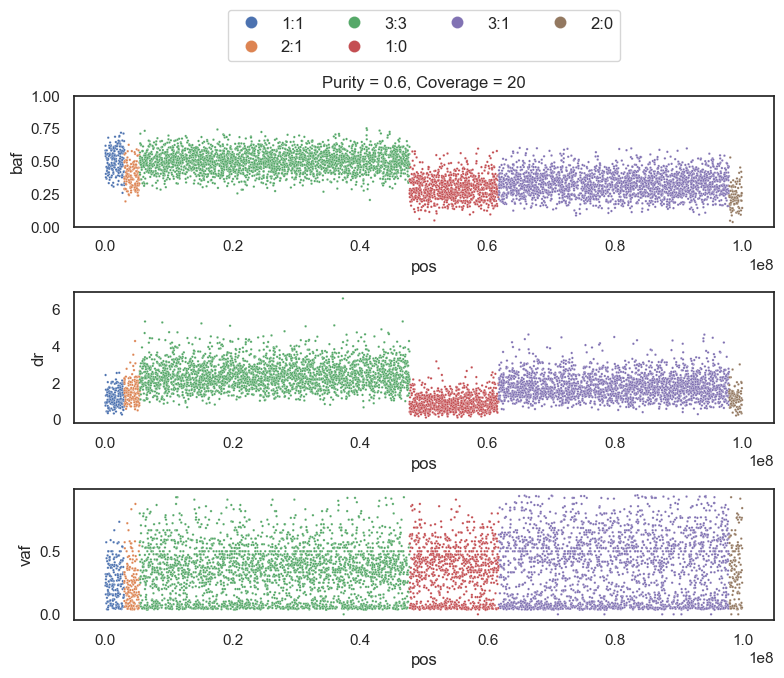

In [6]:
plot_simulations(snp, snv, purity, coverage) 

In [7]:
import locate.locate as l
from locate.posterior import PosteriorTracker
from locate.models import Clonal
from locate.utils import plot_loss

In [8]:
tracker = PosteriorTracker(["purity"]) 

In [9]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         #"vaf": data_input["vaf"], 
                         #"dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "fix_ploidy": True,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1],
                         "hidden_dim":4, 
                         'init_probs': torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [10]:
ll = locate.run(steps = 20, param_optimizer = {"lr" : 0.05}, callback=tracker)

/Users/lucreziavaleriani/Documents/GitHub/locate/src/locate/models/Clonal.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((1 - self._params["jumping_prob"]) * torch.eye(x.shape[0]) + self._params["jumping_prob"])
/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 327.502098891  :   0%|          | 0/20 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: Trace

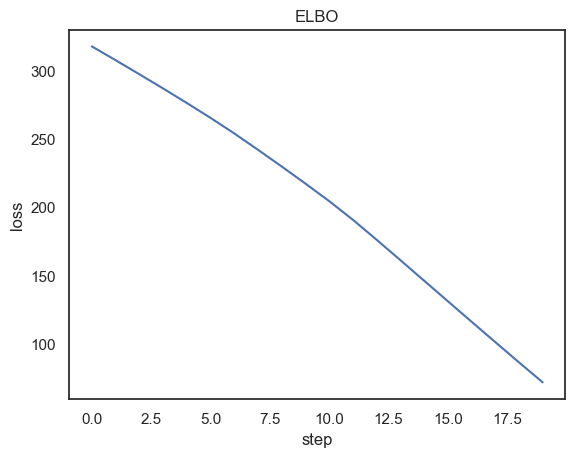

In [11]:
plot_loss(ll[0])


/Users/lucreziavaleriani/Documents/GitHub/locate/src/locate/posterior.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


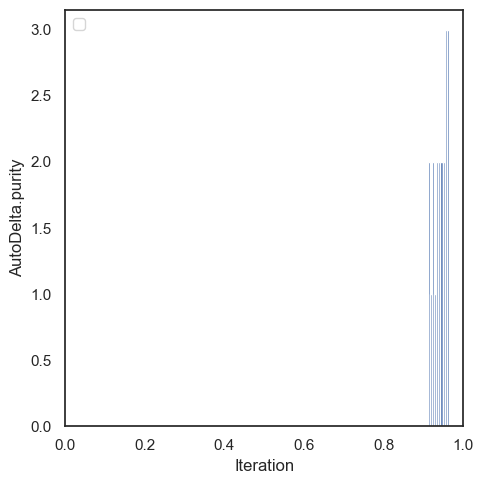

In [12]:
tracker.plot()

In [13]:
from locate.model_checks import run_model_checking
checker = run_model_checking(locate)

Tracking parameters during training...


AttributeError: 'LOCATE' object has no attribute 'optimizer_params'

In [ ]:
params = locate.learned_parameters_Clonal()

In [ ]:
print(params['purity'])
#print(params['ploidy'])

[0.6938162]


In [ ]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

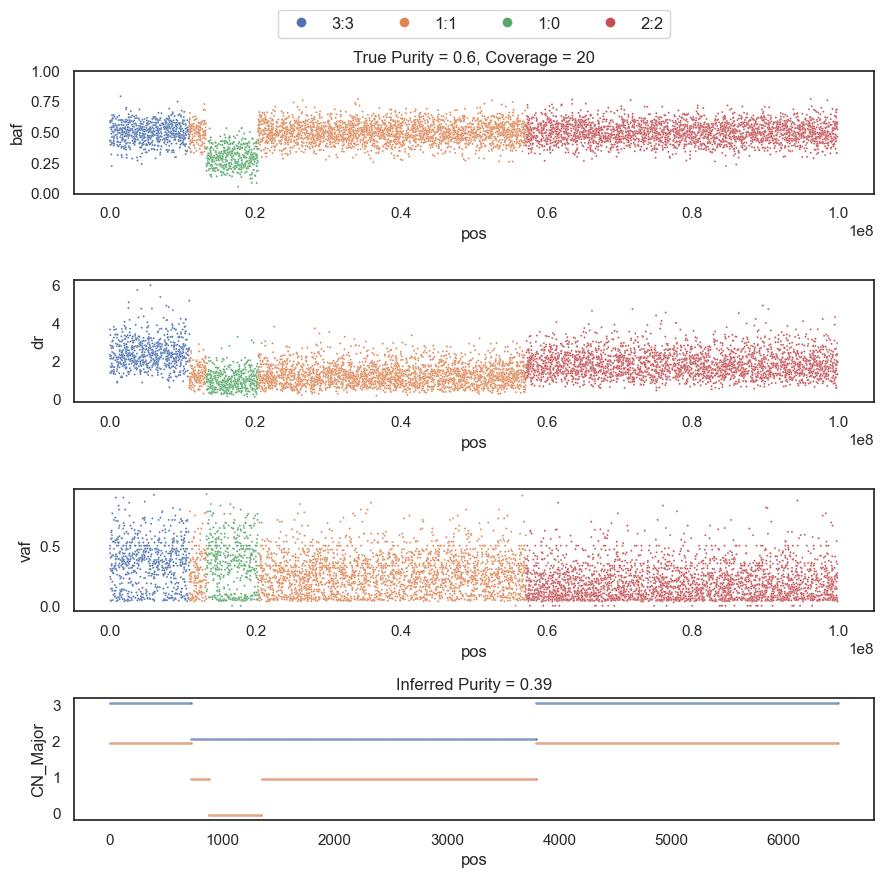

In [ ]:
plot_results_simulations(snp, snv, res, params, purity, coverage)